In [1]:
from robustbench.data import load_cifar10, _load_dataset, PREPROCESSINGS
from autoattack import AutoAttack
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from cupbearer import detectors, scripts, tasks

%pdb on

x_test, y_test = load_cifar10(n_examples=50)

from robustbench.utils import load_model

model = load_model(model_name='Kang2021Stable', dataset='cifar10', threat_model='Linf')
model = model.to('cuda')

Automatic pdb calling has been turned ON
Files already downloaded and verified


In [41]:


def compute_ece(confidences, accuracies, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def run_single_attack_and_report(model, x_test, y_test, attack_name, epsilon, norm='Linf', device='cuda'):
    # Get model predictions on baseline examples
    model.eval()

    with torch.no_grad():
        baseline_logits = model(x_test.to(device))
        baseline_probs = F.softmax(baseline_logits, dim=1)
        baseline_confidences, baseline_pred_classes = baseline_probs.max(dim=1)
    
    baseline_confidences = baseline_confidences.cpu().numpy()
    baseline_pred_classes = baseline_pred_classes.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    baseline_accuracy = (baseline_pred_classes == y_test_np).mean()
    baseline_ece = compute_ece(baseline_confidences, baseline_pred_classes == y_test_np)
    
    baseline_correct_mask = baseline_pred_classes == y_test_np
    baseline_avg_confidence_correct = baseline_confidences[baseline_correct_mask].mean() if baseline_correct_mask.any() else 0
    baseline_avg_confidence_incorrect = baseline_confidences[~baseline_correct_mask].mean() if (~baseline_correct_mask).any() else 0

    # Set up the attack
    adversary = AutoAttack(model, norm=norm, eps=epsilon, version='custom', attacks_to_run=[attack_name])
    
    # Run the single attack
    x = x_test.clone().to(device)
    y = y_test.clone().to(device)
    
    if attack_name == 'apgd-ce':
        adversary.apgd.loss = 'ce'
        adversary.apgd.seed = adversary.get_seed()
        adv_curr = adversary.apgd.perturb(x, y)
    elif attack_name == 'apgd-dlr':
        adversary.apgd.loss = 'dlr'
        adversary.apgd.seed = adversary.get_seed()
        adv_curr = adversary.apgd.perturb(x, y)
    elif attack_name == 'fab':
        adversary.fab.targeted = False
        adversary.fab.seed = adversary.get_seed()
        adv_curr = adversary.fab.perturb(x, y)
    elif attack_name == 'square':
        adversary.square.seed = adversary.get_seed()
        adv_curr = adversary.square.perturb(x, y)
    elif attack_name == 'apgd-t':
        adversary.apgd_targeted.seed = adversary.get_seed()
        adv_curr = adversary.apgd_targeted.perturb(x, y)
    elif attack_name == 'fab-t':
        adversary.fab.targeted = True
        adversary.fab.n_restarts = 1
        adversary.fab.seed = adversary.get_seed()
        adv_curr = adversary.fab.perturb(x, y)
    else:
        raise ValueError('Attack not supported')

    with torch.no_grad():
        logits = model(adv_curr)
        probs = F.softmax(logits, dim=1)
        confidences, pred_classes = probs.max(dim=1)
    
    # Convert to numpy for easier computation
    confidences = confidences.cpu().numpy()
    pred_classes = pred_classes.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    # Compute metrics
    robust_accuracy = (pred_classes == y_test_np).mean()
    ece = compute_ece(confidences, pred_classes == y_test_np)
    
    # Compute adversarial severity (L2 distance between original and adversarial examples)
    adv_severity = torch.norm(adv_curr - x, p=2, dim=(1,2,3)).mean().item()
    
    # Compute average confidence for correct and misclassified examples
    correct_mask = pred_classes == y_test_np
    avg_confidence_correct = confidences[correct_mask].mean() if correct_mask.any() else 0
    avg_confidence_incorrect = confidences[~correct_mask].mean() if (~correct_mask).any() else 0
    
    # Print results
    print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
    print(f"Baseline Expected Calibration Error: {baseline_ece:.4f}")
    print(f"Baseline Avg Confidence (Correct): {baseline_avg_confidence_correct:.4f}")
    print(f"Baseline Avg Confidence (Incorrect): {baseline_avg_confidence_incorrect:.4f}")
    print(f"\nAttack: {attack_name}")
    print(f"Robust Accuracy: {robust_accuracy:.4f}")
    print(f"Expected Calibration Error: {ece:.4f}")
    print(f"Adversarial Severity (L2): {adv_severity:.4f}")
    print(f"Avg Confidence (Correct): {avg_confidence_correct:.4f}")
    print(f"Avg Confidence (Incorrect): {avg_confidence_incorrect:.4f}")
    
    return (adv_curr, robust_accuracy, ece, adv_severity, avg_confidence_correct, 
            avg_confidence_incorrect, baseline_accuracy, baseline_ece, 
            baseline_avg_confidence_correct, baseline_avg_confidence_incorrect)

# Usage
attack_name = 'apgd-t'  # or any other supported attack
epsilon = 8/255  # adjust as needed
(adv_curr, robust_accuracy, ece, adv_severity, avg_confidence_correct, avg_confidence_incorrect,
baseline_accuracy, baseline_ece, baseline_avg_confidence_correct, baseline_avg_confidence_incorrect) = run_single_attack_and_report(model, x_test, y_test, attack_name, epsilon)

Baseline Accuracy: 0.9600
Baseline Expected Calibration Error: 0.0346
Baseline Avg Confidence (Correct): 0.9702
Baseline Avg Confidence (Incorrect): 0.7368

Attack: apgd-t
Robust Accuracy: 0.8600
Expected Calibration Error: 0.0873
Adversarial Severity (L2): 0.1645
Avg Confidence (Correct): 0.9754
Avg Confidence (Incorrect): 0.7744


In [38]:
attack_name = 'fab'  # or any other supported attack
epsilon = 8/255  # adjust as needed
adv_curr, robust_accuracy, ece, adv_severity, avg_confidence_correct, avg_confidence_incorrect, baseline_accuracy, baseline_ece, baseline_avg_confidence_correct, baseline_avg_confidence_incorrect = run_single_attack_and_report(model, x_test, y_test, attack_name, epsilon)

KeyboardInterrupt: 

> /opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py(744)_engine_run_backward()
    742         unregister_hooks = _register_logging_hooks_on_whole_graph(t_outputs)
    743     try:
--> 744         return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    745             t_outputs, *args, **kwargs
    746         )  # Calls into the C++ engine to run the backward pass



In [8]:
names = [name for name, _ in model.named_modules()]
names[-25:]

['layer.2.block.8.se.fc2',
 'layer.2.block.8.se.activation',
 'layer.2.block.8.se.scale_activation',
 'layer.2.block.9',
 'layer.2.block.9.batchnorm_0',
 'layer.2.block.9.relu_0',
 'layer.2.block.9.relu_0.0',
 'layer.2.block.9.relu_0.1',
 'layer.2.block.9.conv_0',
 'layer.2.block.9.batchnorm_1',
 'layer.2.block.9.relu_1',
 'layer.2.block.9.relu_1.0',
 'layer.2.block.9.relu_1.1',
 'layer.2.block.9.conv_1',
 'layer.2.block.9.se',
 'layer.2.block.9.se.avgpool',
 'layer.2.block.9.se.fc1',
 'layer.2.block.9.se.fc2',
 'layer.2.block.9.se.activation',
 'layer.2.block.9.se.scale_activation',
 'batchnorm',
 'relu',
 'relu.0',
 'relu.1',
 'logits']

In [9]:
names[25:50]

['layer.0.block.1.relu_0',
 'layer.0.block.1.relu_0.0',
 'layer.0.block.1.relu_0.1',
 'layer.0.block.1.conv_0',
 'layer.0.block.1.batchnorm_1',
 'layer.0.block.1.relu_1',
 'layer.0.block.1.relu_1.0',
 'layer.0.block.1.relu_1.1',
 'layer.0.block.1.conv_1',
 'layer.0.block.1.se',
 'layer.0.block.1.se.avgpool',
 'layer.0.block.1.se.fc1',
 'layer.0.block.1.se.fc2',
 'layer.0.block.1.se.activation',
 'layer.0.block.1.se.scale_activation',
 'layer.0.block.2',
 'layer.0.block.2.batchnorm_0',
 'layer.0.block.2.relu_0',
 'layer.0.block.2.relu_0.0',
 'layer.0.block.2.relu_0.1',
 'layer.0.block.2.conv_0',
 'layer.0.block.2.batchnorm_1',
 'layer.0.block.2.relu_1',
 'layer.0.block.2.relu_1.0',
 'layer.0.block.2.relu_1.1']

In [8]:
len(names)

129

2024-07-10 05:36:29.386 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:79 - Received multi-dimensional activations, will only learn covariances along last dimension and treat others independently. If this is unintentional, pass `activation_preprocessing_func=utils.flatten_last`.
  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  5.23it/s]
2024-07-10 05:36:30.917 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:311 - Saving detector to logs/cifar10_adv_detection/detector


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

2024-07-10 05:36:31.240 | INFO     | cupbearer.detectors.anomaly_detector:eval:162 - AUC_ROC (all): 0.4988
2024-07-10 05:36:31.240 | INFO     | cupbearer.detectors.anomaly_detector:eval:163 - AP (all): 0.5075
2024-07-10 05:36:31.240 | INFO     | cupbearer.detectors.anomaly_detector:eval:172 - Perfect filter remainder (all): 0.040000000000000036
2024-07-10 05:36:31.241 | INFO     | cupbearer.detectors.anomaly_detector:eval:186 - AUC_ROC_AGREE (all): 0.5000
2024-07-10 05:36:31.241 | INFO     | cupbearer.detectors.anomaly_detector:eval:187 - AP_AGREE (all): 0.5000
2024-07-10 05:36:31.243 | INFO     | cupbearer.detectors.anomaly_detector:eval:202 - AUC_ROC_DISAGREE (all): 0.4988
2024-07-10 05:36:31.243 | INFO     | cupbearer.detectors.anomaly_detector:eval:203 - AP_DISAGREE (all): 0.5075
/mnt/ssd-1/david/cupbearer/src/cupbearer/detectors/anomaly_detector.py:258: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.savefig(save_path / f"histogram_{layer}_{agre

(defaultdict(dict,
             {'all': {'AUC_ROC': 0.49879999999999997,
               'AP': 0.5075116993792658,
               'Perfect_filter_remainder': 0.040000000000000036,
               'AUC_ROC_AGREE': 0.5,
               'AP_AGREE': 0.5,
               'AUC_ROC_DISAGREE': 0.49879999999999997,
               'AP_DISAGREE': 0.5075116993792658}}),
 {('all', 'Disagree'): <Figure size 640x480 with 1 Axes>,
  ('all', 'Agree'): <Figure size 640x480 with 1 Axes>})

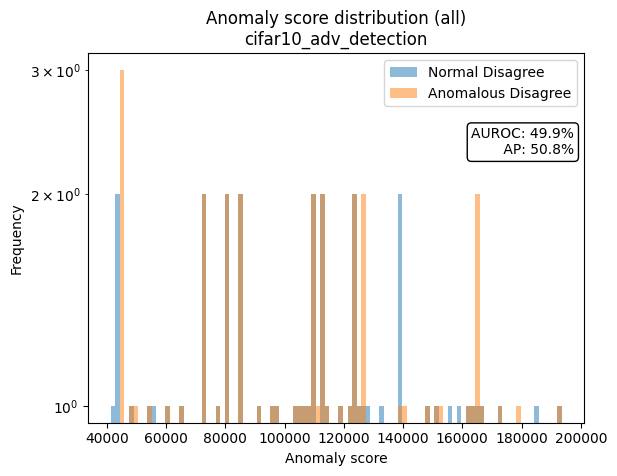

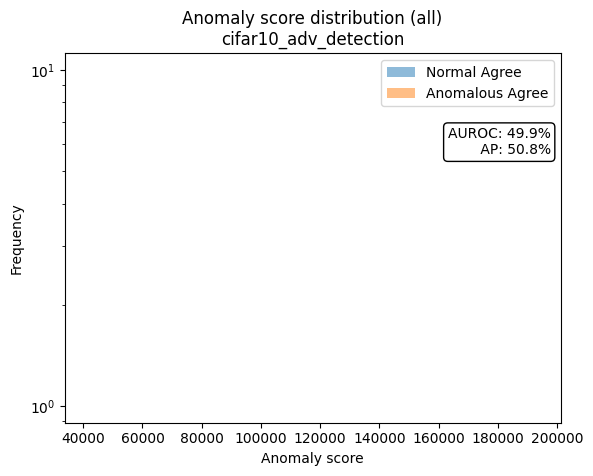

In [14]:



# x_train, y_train = _load_dataset(datasets.CIFAR10(root='./data', train=True, download=True, transform=PREPROCESSINGS[None]), n_examples=500)
# x_test, y_test = _load_dataset(datasets.CIFAR10(root='./data', train=False, download=True, transform=PREPROCESSINGS[None]), n_examples=50)

# # Load the model (assuming you've already loaded it as 'model')
# model = load_model(model_name='Amini2024MeanSparse', dataset='cifar10', threat_model='Linf')
# model = model.to('cuda')

# # Create adversarial examples
# epsilon = 8/255
# adversary = AutoAttack(model, norm='Linf', eps=epsilon, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'])
# adversary.apgd.loss = 'ce'
# adversary.apgd.seed = adversary.get_seed()
# adv_curr = adversary.apgd.perturb(x_test, y_test)

# Combine clean and adversarial test sets
combined_test_images = torch.cat([x_test.to('cuda'), adv_curr], dim=0)
combined_test_labels = torch.cat([y_test, y_test], dim=0)

class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

combined_test = CombinedDataset(combined_test_images, combined_test_labels)

# Create the task
task = tasks.Task.from_separate_data(
    model=model,
    trusted_data=x_train,
    clean_test_data=CombinedDataset(combined_test_images[:len(x_test)], combined_test_labels[:len(x_test)]),
    anomalous_test_data=CombinedDataset(combined_test_images[len(x_test):], combined_test_labels[len(x_test):]),
)

# Define the activation name for a middle layer
# You'll need to adjust this based on your model's architecture
# activation_name = "block2.layer.0.bn1.input"
activation_name = "layer.1.block.1.batchnorm_0.input"

# Create the detector
detector = detectors.MahalanobisDetector(
    activation_names=[activation_name],
    activation_processing_func=lambda x, *args: x,  # Identity function
)

# Train and evaluate the detector
scripts.train_detector(
    task,
    detector,
    save_path="logs/cifar10_adv_detection",
    eval_batch_size=64,
    batch_size=64,
)

In [48]:
cifar10

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        